<a href="https://colab.research.google.com/github/Vaish2511/-Adversarial-Attacks-on-Machine-Learning-based-Network-Intrusion-Detection-Systems-ML---NIDS-/blob/main/Attacks_on_ML_NIDS.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

Importing Libraries

In [ ]:
import pandas as pd
import numpy as np
import gc
import seaborn as sns
import matplotlib.pyplot as plt
import altair as alt

import math

import warnings
import random

from scipy import stats
from scipy.stats import skew
from scipy.stats import  chi2, chi2_contingency

from sklearn.utils.class_weight import compute_class_weight
from sklearn.model_selection import train_test_split
from sklearn.feature_selection import mutual_info_regression
from sklearn.decomposition import PCA
from sklearn.preprocessing import MinMaxScaler, StandardScaler
from sklearn.preprocessing import LabelEncoder, OneHotEncoder
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report, accuracy_score
from sklearn.model_selection import RandomizedSearchCV, cross_val_score
from sklearn.exceptions import DataConversionWarning
from sklearn.linear_model import LogisticRegression
from sklearn.metrics.pairwise import cosine_similarity

from imblearn.over_sampling import SMOTE
from imblearn.under_sampling import RandomUnderSampler
from imblearn.pipeline import Pipeline

import joblib
from joblib import Parallel, delayed

import tensorflow as tf
import keras
from tensorflow.keras import layers, models
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, BatchNormalization, Dropout, LeakyReLU
from tensorflow.keras.initializers import HeNormal
from tensorflow.keras.regularizers import l1, l2
from tensorflow.keras.optimizers import SGD

from sklearn.metrics import accuracy_score, recall_score, precision_score, f1_score, confusion_matrix, classification_report, roc_auc_score, roc_curve

Loading Data

In [ ]:
from google.colab import files
!cp '/content/drive/MyDrive/EE8223 Project/kaggle.json' '/content'
import zipfile
import os

cp: cannot stat '/content/drive/MyDrive/EE8223 Project/kaggle.json': No such file or directory


In [ ]:
os.environ['KAGGLE_CONFIG_DIR'] = "/content"
!kaggle datasets download -d mrwellsdavid/unsw-nb15
with zipfile.ZipFile("unsw-nb15.zip", 'r') as zip_ref:
    zip_ref.extractall("/content")

Dataset URL: https://www.kaggle.com/datasets/mrwellsdavid/unsw-nb15
License(s): unknown
unsw-nb15.zip: Skipping, found more recently modified local copy (use --force to force download)


Inspecting Dataset

In [ ]:
training_set = pd.read_csv('/content/UNSW_NB15_training-set.csv')
testing_set = pd.read_csv('/content/UNSW_NB15_testing-set.csv')
list_events = pd.read_csv('/content/UNSW-NB15_LIST_EVENTS.csv')
NB15_1 = pd.read_csv('/content/UNSW-NB15_1.csv')
NB15_2 = pd.read_csv('/content/UNSW-NB15_2.csv')
NB15_3 = pd.read_csv('/content/UNSW-NB15_3.csv')
NB15_4 = pd.read_csv('/content/UNSW-NB15_4.csv')
NB15_features = pd.read_csv('/content/NUSW-NB15_features.csv', encoding='cp1252')

<ipython-input-3-567d49afcf64>:4: DtypeWarning: Columns (1,3,47) have mixed types. Specify dtype option on import or set low_memory=False.
  NB15_1 = pd.read_csv('/content/UNSW-NB15_1.csv')
<ipython-input-3-567d49afcf64>:5: DtypeWarning: Columns (3,39,47) have mixed types. Specify dtype option on import or set low_memory=False.
  NB15_2 = pd.read_csv('/content/UNSW-NB15_2.csv')


Concatinating Data

In [ ]:
NB15_1.columns = NB15_features['Name']
NB15_2.columns = NB15_features['Name']
NB15_3.columns = NB15_features['Name']
NB15_4.columns = NB15_features['Name']
train_df = pd.concat([NB15_1, NB15_2, NB15_3, NB15_4], ignore_index=True)
train_df = train_df.sample(frac=1, random_state=42).reset_index(drop=True)

Dropping Duplicates

In [ ]:
train_df = train_df.drop_duplicates()

Handling Null Values

In [ ]:
# NaN values implies that no attack are there for that particular row data, Replace NaN values in the 'attack_cat' column with 'not attacked'
train_df['attack_cat'].fillna('normal',inplace = True)
train_df['attack_cat'] = train_df['attack_cat'].apply(lambda x: x.strip().lower())

# Missing values imply that there were no flows with HTTP methods in certain instances so we will replace the NAN with 0
train_df['ct_flw_http_mthd'].fillna(0, inplace=True)

# is_ftp_login is of type binary that mean it takes 1(user has loged in) or 0 (or not) so the best approch is to replace nan with 0
train_df['is_ftp_login'].fillna(0, inplace=True)

<ipython-input-6-f8da52e83dd1>:2: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  train_df['attack_cat'].fillna('normal',inplace = True)
<ipython-input-6-f8da52e83dd1>:6: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try 

Unique Values

In [ ]:
train_df['ct_ftp_cmd'] = train_df['ct_ftp_cmd'].astype('str')
train_df['ct_ftp_cmd'].dtype
train_df['ct_ftp_cmd'].unique()
train_df['ct_ftp_cmd'] = train_df['ct_ftp_cmd'].replace(' ', '0')
train_df['ct_ftp_cmd'] = train_df['ct_ftp_cmd'].astype('int')
train_df['ct_ftp_cmd'].dtype
train_df['ct_ftp_cmd'].unique()

array([0, 1, 2, 4, 5, 3, 6, 8])

**Handling 'is-ftp_login' column:**

In column 'is_ftp_login', unique values are [0, 1, 2, 4] which is not correct because according to given NB15_features.csv this column is a binary column.

In [ ]:
def convert_to_binary(df, column):
    df[column] = (df[column] > 0).astype(int)
    return df

column = 'is_ftp_login'
convert_to_binary(train_df, column)

Name,srcip,sport,dstip,dsport,proto,state,dur,sbytes,dbytes,sttl,...,ct_ftp_cmd,ct_srv_src,ct_srv_dst,ct_dst_ltm,ct_src_ ltm,ct_src_dport_ltm,ct_dst_sport_ltm,ct_dst_src_ltm,attack_cat,Label
0,175.45.176.3,57672,149.171.126.15,3260,tcp,CON,0.285356,986,86,62,...,0,10,8,4,5,3,1,7,normal,0
1,59.166.0.8,38052,149.171.126.9,6881,tcp,FIN,0.314311,1540,1644,31,...,0,14,6,8,12,5,1,6,normal,0
2,59.166.0.0,42911,149.171.126.2,38558,udp,CON,0.301180,536,304,31,...,0,9,16,7,6,1,1,3,normal,0
3,175.45.176.1,47439,149.171.126.14,53,udp,INT,0.000009,114,0,254,...,0,33,33,17,17,17,17,33,generic,1
4,59.166.0.5,61544,149.171.126.6,53,udp,CON,0.001079,146,178,31,...,0,2,2,5,4,1,1,1,normal,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2540035,59.166.0.2,29290,149.171.126.9,143,tcp,FIN,0.031870,7820,15060,31,...,0,5,6,1,4,1,1,1,normal,0
2540037,59.166.0.0,18378,149.171.126.0,17406,udp,CON,0.035147,528,304,31,...,0,11,4,3,7,1,1,1,normal,0
2540038,59.166.0.8,34415,149.171.126.0,5190,tcp,FIN,0.008119,1920,4312,31,...,0,3,10,4,1,1,1,1,normal,0
2540039,59.166.0.8,56352,149.171.126.2,53,udp,CON,0.001047,130,162,31,...,0,1,1,2,6,1,1,1,normal,0


In [ ]:
train_df['sport'] = train_df['sport'].astype('str')
train_df['sport'] = pd.to_numeric(train_df['sport'], errors='coerce').fillna(0).astype(int)
train_df['dsport'] = train_df['dsport'].astype('str')
train_df['dsport'] = pd.to_numeric(train_df['dsport'], errors='coerce').fillna(0).astype(int)

Checking for Outliers

In [ ]:
numerical_columns = train_df.select_dtypes(include=['float64', 'int64']).columns.tolist()
len(numerical_columns)

26

In [ ]:
numerical_columns = train_df.select_dtypes(include=['float64', 'int64']).columns.tolist()
exclude_columns = ['sport', 'swim', 'dwim', 'stcpb', 'dtcpb', 'Stime', 'Ltime']
numerical_columns = [col for col in numerical_columns if col not in exclude_columns]

In [ ]:
for col in numerical_columns:
    median_value = train_df[col].median()
    lower_bound = train_df[col].quantile(0.25) - 1.5 * (train_df[col].quantile(0.75) - train_df[col].quantile(0.25))
    upper_bound = train_df[col].quantile(0.75) + 1.5 * (train_df[col].quantile(0.75) - train_df[col].quantile(0.25))
    train_df[col] = train_df[col].apply(lambda x: median_value if x < lower_bound or x > upper_bound else x)

Visualising Data Distribution and Skewness

<ipython-input-40-4eabbd693761>:17: RuntimeWarning: Precision loss occurred in moment calculation due to catastrophic cancellation. This occurs when the data are nearly identical. Results may be unreliable.
  skewness = skew(train_df[col].dropna())
<ipython-input-40-4eabbd693761>:17: RuntimeWarning: Precision loss occurred in moment calculation due to catastrophic cancellation. This occurs when the data are nearly identical. Results may be unreliable.
  skewness = skew(train_df[col].dropna())
<ipython-input-40-4eabbd693761>:17: RuntimeWarning: Precision loss occurred in moment calculation due to catastrophic cancellation. This occurs when the data are nearly identical. Results may be unreliable.
  skewness = skew(train_df[col].dropna())
<ipython-input-40-4eabbd693761>:17: RuntimeWarning: Precision loss occurred in moment calculation due to catastrophic cancellation. This occurs when the data are nearly identical. Results may be unreliable.
  skewness = skew(train_df[col].dropna())


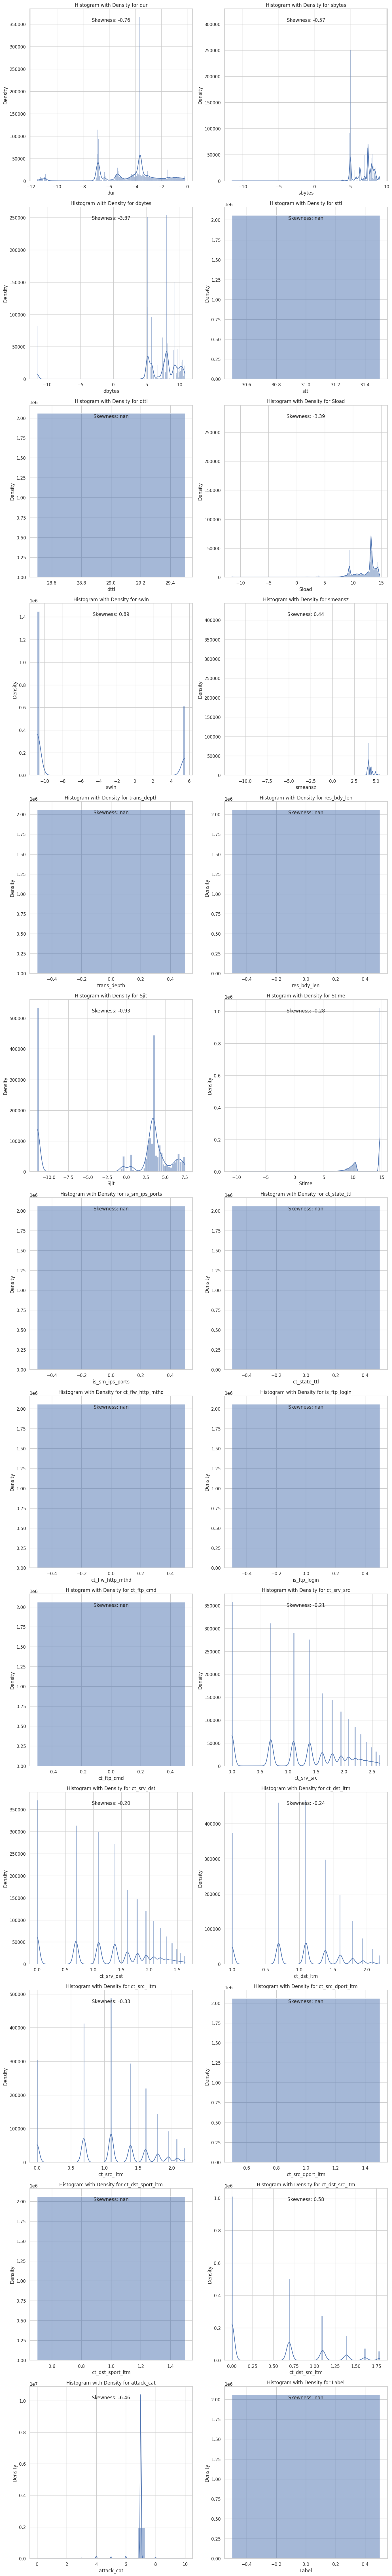

In [ ]:
numerical_features = train_df.select_dtypes(include=['number']).columns
num_plots = len(numerical_features)

# Ensure enough rows to accommodate all features
num_rows = (num_plots + 1) // 2

fig, axes = plt.subplots(nrows=num_rows, ncols=2, figsize=(14, 7*num_rows))

# Flatten the axes array for easy indexing
axes = axes.flatten()

# Loop through the selected columns and create histograms with density
for i, col in enumerate(numerical_features):
    sns.histplot(data=train_df, x=col, kde=True, ax=axes[i])
    axes[i].set_title(f'Histogram with Density for {col}')
    axes[i].set_xlabel(col)
    axes[i].set_ylabel('Density')

    # Calculate skewness
    skewness = skew(train_df[col].dropna())
    axes[i].text(0.5, 0.95, f'Skewness: {skewness:.2f}', horizontalalignment='center', verticalalignment='top', transform=axes[i].transAxes)

# Remove any empty subplots if the number of features is odd
if num_plots % 2 != 0:
    fig.delaxes(axes[-1])

plt.tight_layout()
plt.show()

In [ ]:
def transform(X):
    eps = 1e-5
    numerical_columns = X.select_dtypes(include=['float64', 'int64']).columns.tolist()

    for col in numerical_columns:
        skewness = skew(X[col])
        if skewness > 0:  # Positive skew
            X[col] = np.log(X[col] + eps)
        elif skewness < 0:  # Negative skew
            X[col] = np.log(np.max(X[col] + eps) - X[col] + eps)
        else:  # Symmetric or zero skew
            X[col] = X[col]  # No transformation needed

    return X
transform(train_df)

<ipython-input-12-385160cef361>:6: RuntimeWarning: Precision loss occurred in moment calculation due to catastrophic cancellation. This occurs when the data are nearly identical. Results may be unreliable.
  skewness = skew(X[col])


Name,srcip,sport,dstip,dsport,proto,state,dur,sbytes,dbytes,sttl,...,ct_ftp_cmd,ct_srv_src,ct_srv_dst,ct_dst_ltm,ct_src_ ltm,ct_src_dport_ltm,ct_dst_sport_ltm,ct_dst_src_ltm,attack_cat,Label
0,175.45.176.3,8.969923,149.171.126.15,8.089482,tcp,CON,-1.253983,6.893656,4.454347,31.0,...,0.0,2.302586,2.079443,1.386297,1.609440,1.0,1.0,0.693152,normal,0.0
1,59.166.0.8,10.221323,149.171.126.9,8.836519,tcp,FIN,-1.157341,7.339538,7.404888,31.0,...,0.0,2.639058,1.791761,2.079443,1.098616,1.0,1.0,1.791761,normal,0.0
2,59.166.0.0,10.026767,149.171.126.2,10.559919,udp,CON,-1.200014,6.284134,5.717028,31.0,...,0.0,2.197226,1.386297,1.945912,1.791761,1.0,1.0,1.098616,normal,0.0
3,175.45.176.1,9.803446,149.171.126.14,3.970292,udp,INT,-10.871072,4.736199,-11.512925,31.0,...,0.0,1.386297,1.386297,1.098616,1.098616,1.0,1.0,0.693152,generic,0.0
4,59.166.0.5,8.291797,149.171.126.6,3.970292,udp,CON,-6.822495,4.983607,5.181784,31.0,...,0.0,0.693152,0.693152,1.609440,1.386297,1.0,1.0,0.000010,normal,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2540035,59.166.0.2,10.498057,149.171.126.9,4.962845,tcp,FIN,-3.445776,8.964440,9.619798,31.0,...,0.0,1.609440,1.791761,0.000010,1.386297,1.0,1.0,0.000010,normal,0.0
2540037,59.166.0.0,10.761238,149.171.126.0,9.764570,udp,CON,-3.347932,6.269096,5.717028,31.0,...,0.0,2.397896,1.386297,1.098616,1.945912,1.0,1.0,0.000010,normal,0.0
2540038,59.166.0.8,10.345606,149.171.126.0,8.554489,tcp,FIN,-4.812317,7.560080,8.369157,31.0,...,0.0,1.098616,2.302586,1.386297,0.000010,1.0,1.0,0.000010,normal,0.0
2540039,59.166.0.8,9.125109,149.171.126.2,3.970292,udp,CON,-6.852321,4.867535,5.087596,31.0,...,0.0,0.000010,0.000010,0.693152,1.791761,1.0,1.0,0.000010,normal,0.0


In [ ]:
columns_to_drop = ['sport', 'dsport', 'proto','srcip', 'dstip','state', 'service']
train_df.drop(columns=columns_to_drop, inplace=True)
cat_columns = train_df.select_dtypes(include=['O']).columns.tolist()
cat_columns

['attack_cat']

Target Feature Encoding

In [ ]:
label_encoder = LabelEncoder()
ohe = OneHotEncoder()

In [ ]:
train_df['attack_cat'] = label_encoder.fit_transform(train_df['attack_cat'])

In [ ]:
label_mapping = dict(zip(label_encoder.classes_, label_encoder.transform(label_encoder.classes_)))
print("Label Mapping:")
print(label_mapping)

Label Mapping:
{'analysis': 0, 'backdoor': 1, 'backdoors': 2, 'dos': 3, 'exploits': 4, 'fuzzers': 5, 'generic': 6, 'normal': 7, 'reconnaissance': 8, 'shellcode': 9, 'worms': 10}


Checking Correlated Features

<Axes: title={'center': 'Correlation Plot'}, xlabel='Name', ylabel='Name'>

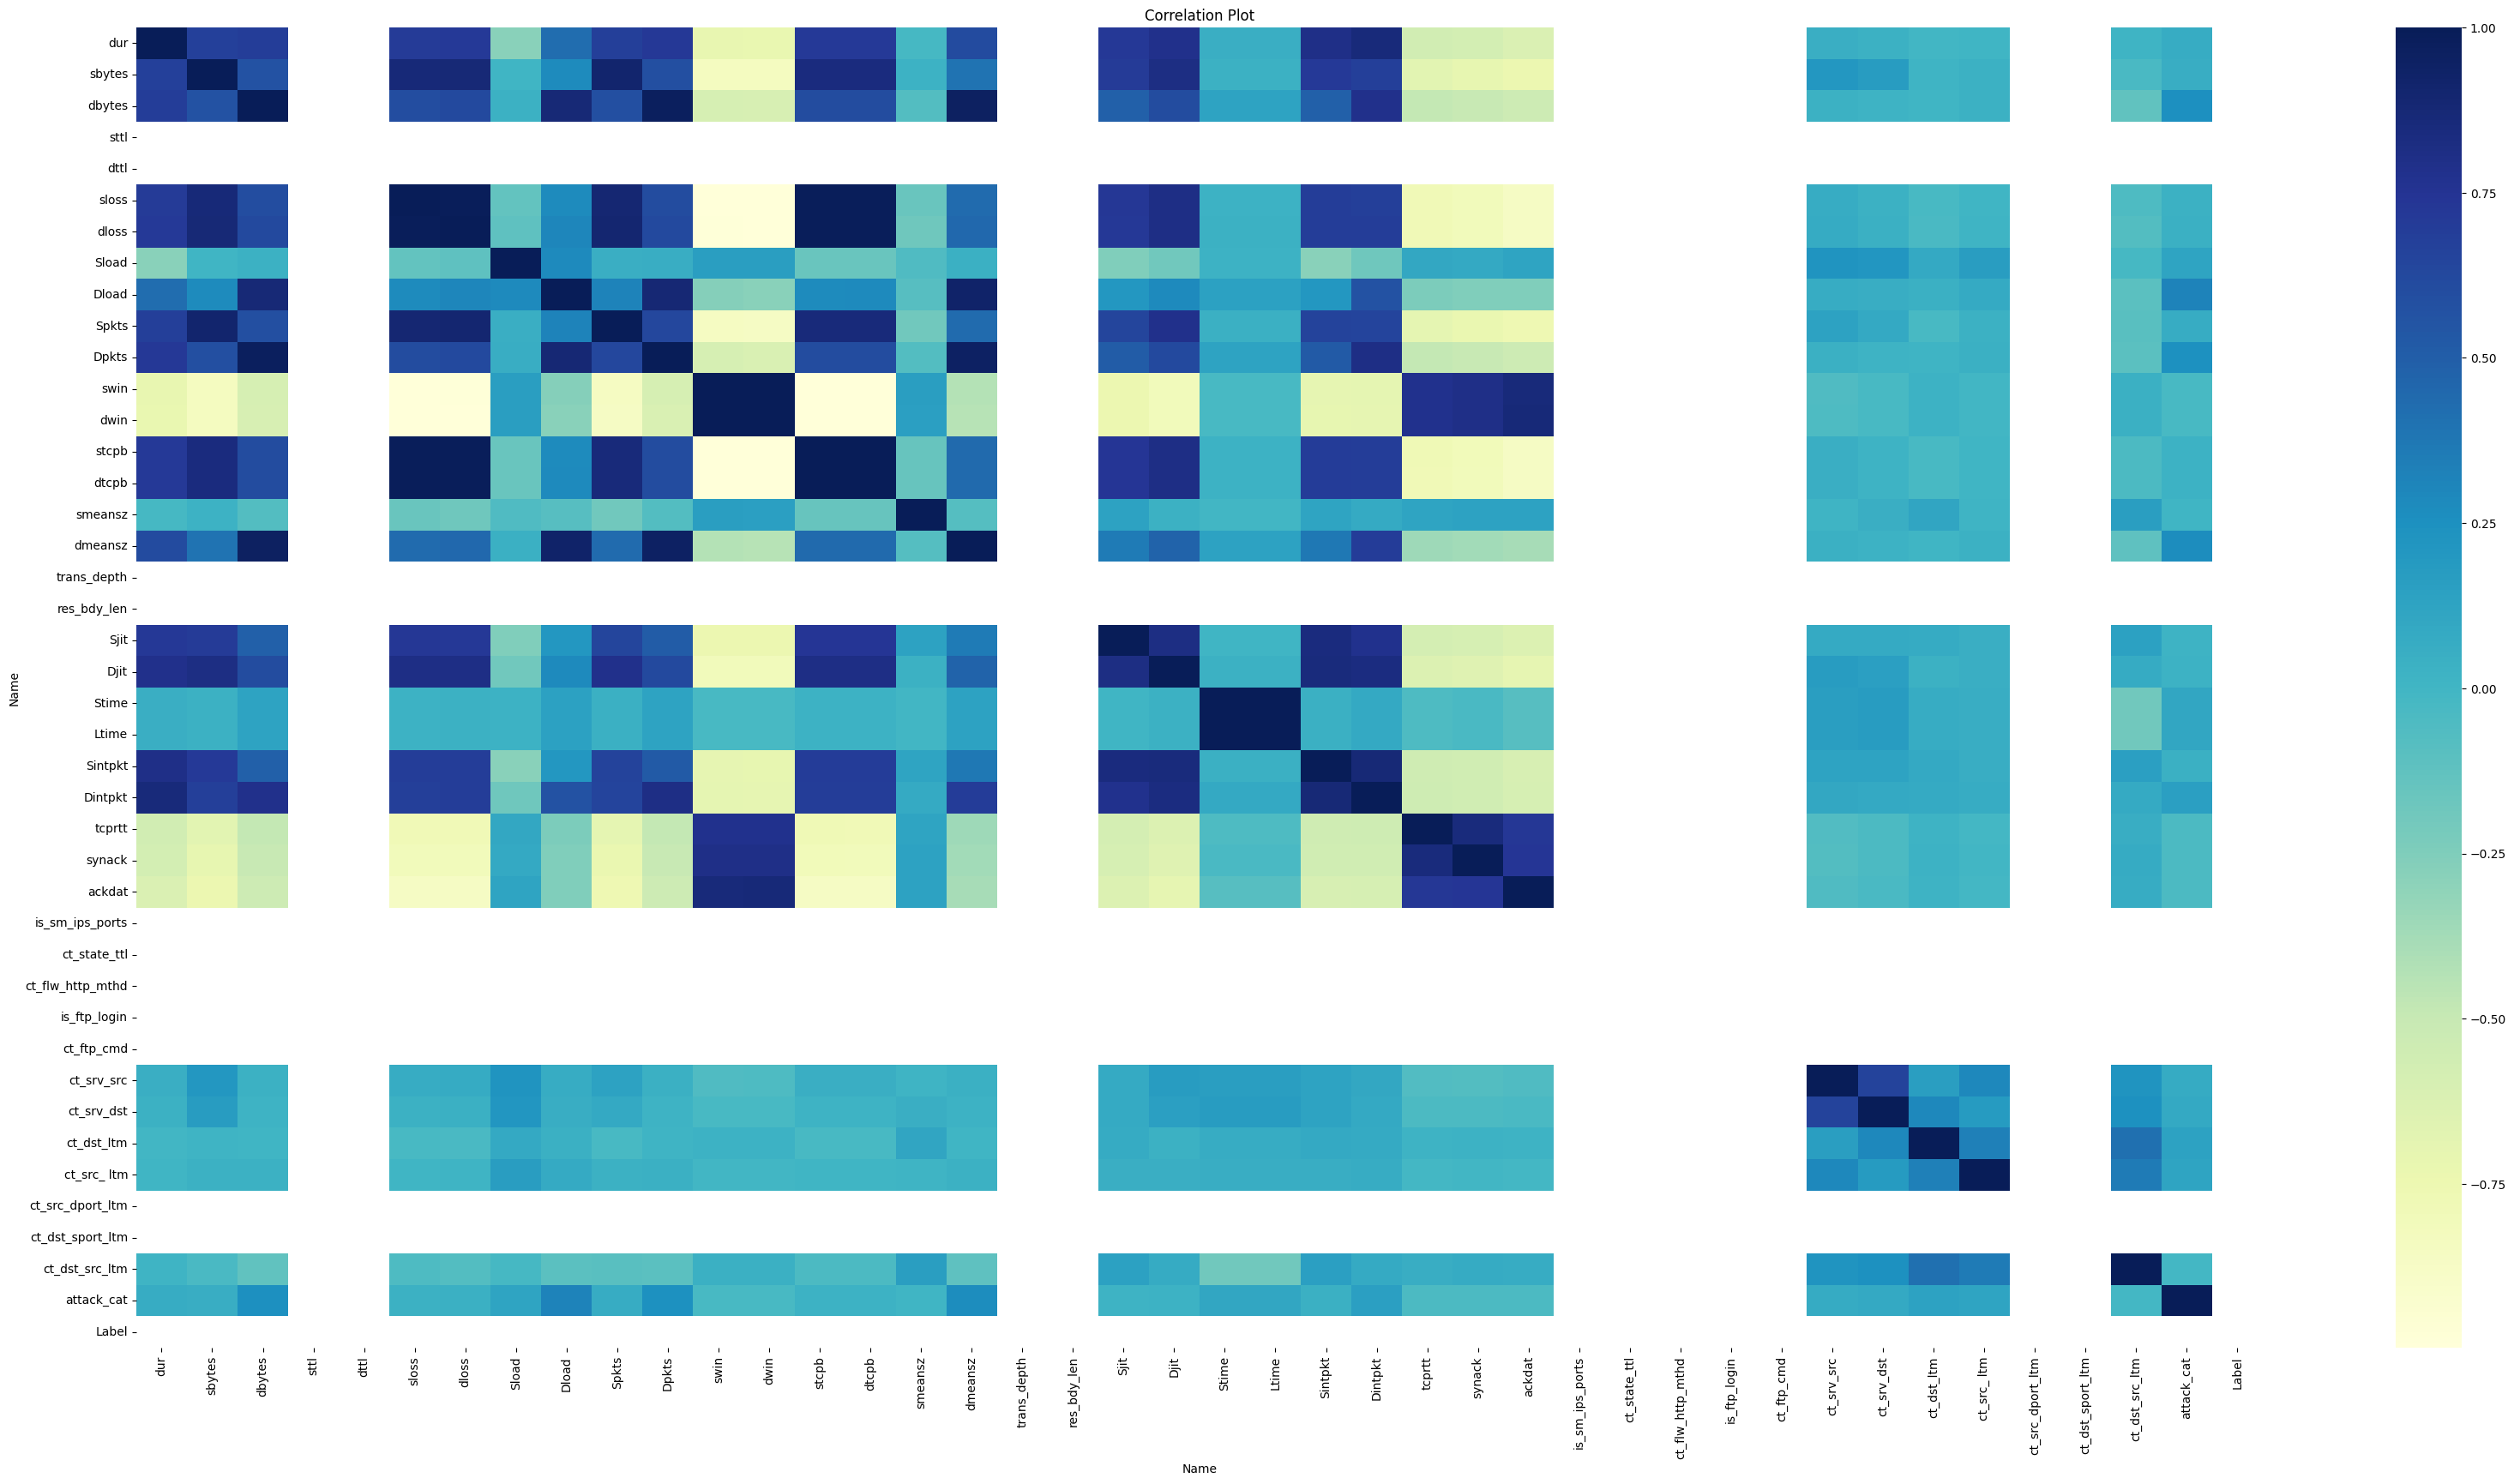

In [ ]:
plt.figure(figsize=(40,20))
plt.title("Correlation Plot")
sns.heatmap(train_df.corr(),cmap='YlGnBu')

In [ ]:
correlation_matrix = train_df.corr()

# Create a mask to identify the features with a correlation coefficient greater than or equal to 0.75
high_correlation_mask = correlation_matrix >= 0.75

# Identify and list the highly correlated features
highly_correlated_features = []

for feature in high_correlation_mask.columns:
    correlated_with = high_correlation_mask.index[high_correlation_mask[feature]].tolist()
    for correlated_feature in correlated_with:
        if feature != correlated_feature and (correlated_feature, feature) not in highly_correlated_features:
            highly_correlated_features.append((feature, correlated_feature))
print("Highly correlated features:")
for feature1, feature2 in highly_correlated_features:
    print(f"{feature1} and {feature2}")

Highly correlated features:
dur and Djit
dur and Sintpkt
dur and Dintpkt
sbytes and sloss
sbytes and dloss
sbytes and Spkts
sbytes and stcpb
sbytes and dtcpb
sbytes and Djit
dbytes and Dload
dbytes and Dpkts
dbytes and dmeansz
dbytes and Dintpkt
sloss and dloss
sloss and Spkts
sloss and stcpb
sloss and dtcpb
sloss and Djit
dloss and Spkts
dloss and stcpb
dloss and dtcpb
dloss and Djit
Dload and Dpkts
Dload and dmeansz
Spkts and stcpb
Spkts and dtcpb
Spkts and Djit
Dpkts and dmeansz
Dpkts and Dintpkt
swin and dwin
swin and tcprtt
swin and synack
swin and ackdat
dwin and tcprtt
dwin and synack
dwin and ackdat
stcpb and dtcpb
stcpb and Djit
dtcpb and Djit
Sjit and Djit
Sjit and Sintpkt
Sjit and Dintpkt
Djit and Sintpkt
Djit and Dintpkt
Stime and Ltime
Sintpkt and Dintpkt
tcprtt and synack


In [ ]:
features_to_drop = set()

# Iterate over the highly correlated features and add one of each pair to the drop list
for feature1, feature2 in highly_correlated_features:
    if feature1 not in features_to_drop and feature2 not in features_to_drop:
        features_to_drop.add(feature2)

# Drop the features from the DataFrame
train_df = train_df.drop(columns=features_to_drop)

print("Remaining features after dropping highly correlated ones:")
print(train_df.columns)

Remaining features after dropping highly correlated ones:
Index(['dur', 'sbytes', 'dbytes', 'sttl', 'dttl', 'Sload', 'swin', 'smeansz',
       'trans_depth', 'res_bdy_len', 'Sjit', 'Stime', 'is_sm_ips_ports',
       'ct_state_ttl', 'ct_flw_http_mthd', 'is_ftp_login', 'ct_ftp_cmd',
       'ct_srv_src', 'ct_srv_dst', 'ct_dst_ltm', 'ct_src_ ltm',
       'ct_src_dport_ltm', 'ct_dst_sport_ltm', 'ct_dst_src_ltm', 'attack_cat',
       'Label'],
      dtype='object', name='Name')


In [ ]:
x = train_df.drop(['attack_cat'], axis=1)
y = train_df[['attack_cat']]

Balancing the Unbalanced Data

In [ ]:
# Define the desired number of samples for each class
desired_count = 15000

# Define the oversampling strategy for SMOTE
oversample_strategy = {i: desired_count for i in range(len(y.value_counts())) if y.value_counts()[i] < desired_count}

# Define the undersampling strategy for RandomUnderSampler
undersample_strategy = {i: desired_count for i in range(len(y.value_counts())) if y.value_counts()[i] > desired_count}

smote = SMOTE(sampling_strategy=oversample_strategy)
undersample = RandomUnderSampler(sampling_strategy=undersample_strategy)

# Combine SMOTE and RandomUnderSampler in a pipeline
pipeline = Pipeline(steps=[('smote', smote), ('undersample', undersample)])

# Print class distribution before resampling
print("Before resampling:", y.value_counts())
print()

# Apply the pipeline to resample the dataset
x_resampled, y_resampled = pipeline.fit_resample(x, y)

# Print class distribution after resampling
print("After resampling:", y_resampled.value_counts())

Before resampling: attack_cat
7             1959771
4               27600
6               25378
5               21795
8               13357
3                5665
0                2185
1                1684
9                1511
2                 300
10                171
Name: count, dtype: int64

After resampling: attack_cat
0             15000
1             15000
2             15000
3             15000
4             15000
5             15000
6             15000
7             15000
8             15000
9             15000
10            15000
Name: count, dtype: int64


In [ ]:
x = x_resampled
y = y_resampled

Mutual Information Scores to check Feature Importance

In [ ]:
discrete_features = x.dtypes == int

def mi_score_maker(x,y,discrete_features):
    scores = mutual_info_regression(x,y,discrete_features=discrete_features)
    df = pd.DataFrame({
        'Features':x.columns,
        'Scores':scores})

    df = df.sort_values(['Scores'],ascending=False).reset_index(drop=True)
    return df

In [ ]:
mi_scores = mi_score_maker(x,y.astype('float64'),discrete_features)
mi_scores

/usr/local/lib/python3.10/dist-packages/sklearn/utils/validation.py:1339: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


,Features,Scores
0,sbytes,1.305588
1,smeansz,1.061647
2,dbytes,0.744636
3,Stime,0.602560
4,dur,0.518220
5,ct_srv_dst,0.458908
6,ct_srv_src,0.431506
7,Sload,0.391632
8,ct_dst_src_ltm,0.323135
9,ct_dst_ltm,0.316414


In [ ]:
low_score_features = mi_scores[mi_scores['Scores'] < 0.01]
low_score_feature_names = low_score_features['Features'].tolist()
low_score_feature_names

['ct_state_ttl',
 'Label',
 'is_ftp_login',
 'ct_flw_http_mthd',
 'is_sm_ips_ports',
 'res_bdy_len',
 'ct_ftp_cmd',
 'trans_depth',
 'dttl',
 'ct_src_dport_ltm',
 'ct_dst_sport_ltm',
 'sttl']

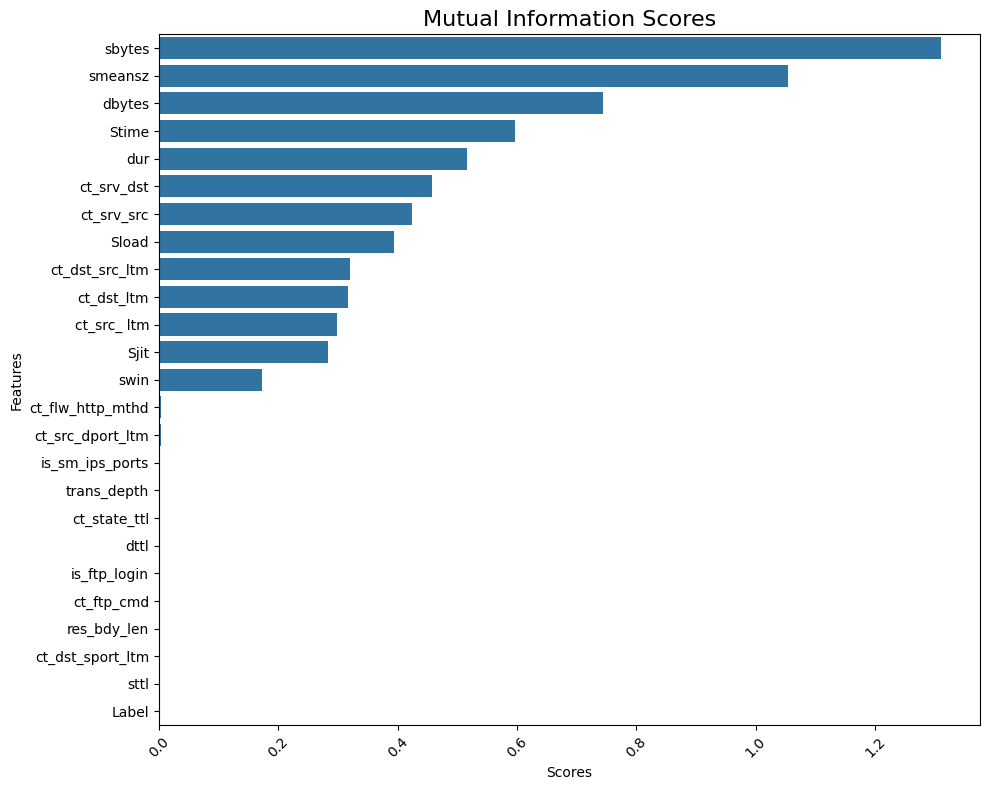

In [ ]:
plt.figure(figsize=(10, 8))
sns.barplot(x='Scores', y='Features', data=mi_scores)
plt.title("Mutual Information Scores", fontsize=16)
plt.yticks(rotation=0)
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

In [ ]:
x.drop(low_score_feature_names,axis=1, inplace = True)
scaler = StandardScaler()
x_scaled = scaler.fit_transform(x)

PCA

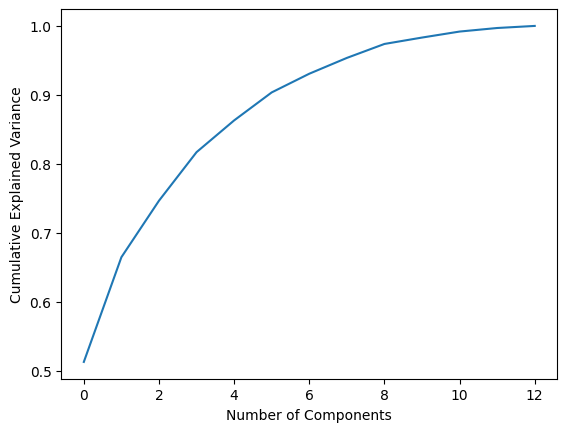

In [ ]:
pca = PCA()
pca.fit(x_scaled)
explained_variance_ratio = pca.explained_variance_ratio_
cumulative_variance_ratio = explained_variance_ratio.cumsum()

plt.plot(cumulative_variance_ratio)
plt.xlabel('Number of Components')
plt.ylabel('Cumulative Explained Variance')
plt.show()

Splitting the Dataset into Training/Testing

In [ ]:
x_train_scaled, x_test_scaled, y_train, y_test = train_test_split(x_scaled, y, test_size=0.2, random_state=42)

Random Forest Classifier

In [ ]:
warnings.filterwarnings(action='ignore', category=DataConversionWarning)

# Define the Random Forest model
rf_model = RandomForestClassifier(random_state=42)

# Define the hyperparameter space
param_dist = {
    'n_estimators': [100, 200, 300, 400, 500],  # Number of trees
    'max_depth': [None, 10, 20, 30, 50],  # Depth of each tree
    'min_samples_split': [2, 5, 10],  # Minimum samples required to split a node
    'min_samples_leaf': [1, 2, 4],  # Minimum samples required to be at a leaf node
    'bootstrap': [True, False]  # Sampling with or without replacement
}

# RandomizedSearchCV for faster hyperparameter tuning
random_search = RandomizedSearchCV(
    estimator=rf_model,
    param_distributions=param_dist,
    n_iter=20,  # Number of random combinations to try
    cv=3,  # 3-fold cross-validation
    n_jobs=-1,  # Use all available CPU cores
    random_state=42,
    verbose=2
)

# Perform Randomized Search
random_search.fit(x_train_scaled, y_train.to_numpy().ravel())

# Retrieve the best parameters
best_params = random_search.best_params_
print("Best Hyperparameters:", best_params)

# Train the best model on the full training set
best_rf_model = random_search.best_estimator_

# Evaluate with cross-validation
cv_scores = cross_val_score(best_rf_model, x_train_scaled, y_train.to_numpy().ravel(), cv=5)
print("Cross-Validation Accuracy (Mean):", np.mean(cv_scores))

# Train the model on the entire training set
best_rf_model.fit(x_train_scaled, y_train.to_numpy().ravel())

# Make predictions on the test set
rf_y_pred = best_rf_model.predict(x_test_scaled)

# Evaluate the model performance
print("Random Forest Classification Report (After Randomized Search Tuning):")
print(classification_report(y_test, rf_y_pred))
print("Random Forest Accuracy (After Randomized Search Tuning):", accuracy_score(y_test, rf_y_pred))

Fitting 3 folds for each of 20 candidates, totalling 60 fits


/usr/local/lib/python3.10/dist-packages/joblib/externals/loky/process_executor.py:752: UserWarning: A worker stopped while some jobs were given to the executor. This can be caused by a too short worker timeout or by a memory leak.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/numpy/ma/core.py:2820: RuntimeWarning: invalid value encountered in cast
  _data = np.array(data, dtype=dtype, copy=copy,


Best Hyperparameters: {'n_estimators': 200, 'min_samples_split': 2, 'min_samples_leaf': 1, 'max_depth': 20, 'bootstrap': False}
Cross-Validation Accuracy (Mean): 0.8047575757575757
Random Forest Classification Report (After Randomized Search Tuning):
              precision    recall  f1-score   support

           0       0.60      0.40      0.48      2895
           1       0.47      0.86      0.61      2924
           2       0.86      0.99      0.92      3064
           3       0.74      0.45      0.56      3000
           4       0.76      0.70      0.73      3032
           5       0.92      0.88      0.90      2942
           6       0.98      0.85      0.91      3035
           7       0.99      0.98      0.98      3040
           8       0.89      0.83      0.85      3060
           9       0.89      0.96      0.92      3017
          10       0.97      1.00      0.98      2991

    accuracy                           0.81     33000
   macro avg       0.82      0.81      0.80  

**Poisoning Attacks**


Label Poisoning

In [ ]:
def label_poisoning_attack(x_train, y_train, attack_fraction=0.2):
    # Ensure y_train is converted to a 1D array
    y_train = np.asarray(y_train).ravel()

    # Step 1: Identify indices for poisoning (attack_fraction of total data)
    n_attack = int(len(y_train) * attack_fraction)
    attack_indices = np.random.choice(len(y_train), size=n_attack, replace=False)

    # Step 2: For each poisoned sample, assign a random incorrect label
    y_train_poisoned = y_train.copy()  # Copy the labels to create poisoned labels
    for idx in attack_indices:
        # Randomly choose a new label that is not the current label
        current_label = y_train[idx]
        possible_labels = np.unique(y_train)
        possible_labels = possible_labels[possible_labels != current_label]
        new_label = random.choice(possible_labels)

        # Assign the new label to the selected sample
        y_train_poisoned[idx] = new_label

    return x_train, y_train_poisoned

# Apply the Label Poisoning attack
x_train_poisoned, y_train_poisoned = label_poisoning_attack(x_train_scaled, y_train, attack_fraction=0.2)

# Train the Random Forest classifier on the poisoned data
rf_model_attack = RandomForestClassifier(n_estimators=100, max_depth=None, min_samples_split=2, random_state=42, n_jobs=-1)
rf_model_attack.fit(x_train_poisoned, y_train_poisoned)

# Make predictions on the test data
rf_y_pred_attack = rf_model_attack.predict(x_test_scaled)

# Evaluate the model performance after poisoning
print("Random Forest Classification Report (Label Poisoning Attack):")
print(classification_report(y_test, rf_y_pred_attack))
print("Random Forest Accuracy (Label Poisoning Attack):", accuracy_score(y_test, rf_y_pred_attack))

Random Forest Classification Report (Label Poisoning Attack):
              precision    recall  f1-score   support

           0       0.46      0.42      0.44      2895
           1       0.51      0.55      0.53      2924
           2       0.79      0.85      0.82      3064
           3       0.55      0.47      0.51      3000
           4       0.66      0.68      0.67      3032
           5       0.79      0.84      0.81      2942
           6       0.83      0.73      0.78      3035
           7       0.92      0.98      0.95      3040
           8       0.76      0.77      0.76      3060
           9       0.83      0.89      0.86      3017
          10       0.90      0.87      0.89      2991

    accuracy                           0.73     33000
   macro avg       0.73      0.73      0.73     33000
weighted avg       0.73      0.73      0.73     33000

Random Forest Accuracy (Label Poisoning Attack): 0.7334242424242424


Feature Poisoning

In [ ]:
def feature_poisoning_attack(x_train, attack_fraction=0.2):
    # Step 1: Identify indices for poisoning (attack_fraction of total data)
    n_attack = int(len(x_train) * attack_fraction)
    attack_indices = np.random.choice(len(x_train), size=n_attack, replace=False)

    # Step 2: Poison the features (set them to random values)
    x_train_poisoned = x_train.copy()
    n_features = x_train.shape[1]

    for idx in attack_indices:
        # Poison the features by setting them to random values
        random_values = np.random.uniform(low=x_train.min(), high=x_train.max(), size=n_features)
        x_train_poisoned[idx] = random_values

    return x_train_poisoned

# Apply the Feature Poisoning attack
x_train_poisoned = feature_poisoning_attack(x_train_scaled, attack_fraction=0.2)

# Train the Random Forest classifier on the poisoned data
rf_model_attack = RandomForestClassifier(n_estimators=100, max_depth=None, min_samples_split=2, random_state=42, n_jobs=-1)
rf_model_attack.fit(x_train_poisoned, y_train)

# Make predictions on the test data
rf_y_pred_attack = rf_model_attack.predict(x_test_scaled)

# Evaluate the model performance after poisoning
print("Random Forest Classification Report (Feature Poisoning Attack):")
print(classification_report(y_test, rf_y_pred_attack))
print("Random Forest Accuracy (Feature Poisoning Attack):", accuracy_score(y_test, rf_y_pred_attack))

Random Forest Classification Report (Feature Poisoning Attack):
              precision    recall  f1-score   support

           0       0.49      0.47      0.48      2895
           1       0.56      0.61      0.58      2924
           2       0.85      0.95      0.89      3064
           3       0.58      0.49      0.53      3000
           4       0.72      0.70      0.71      3032
           5       0.85      0.86      0.86      2942
           6       0.92      0.86      0.89      3035
           7       0.99      0.98      0.98      3040
           8       0.82      0.81      0.82      3060
           9       0.89      0.96      0.92      3017
          10       0.98      1.00      0.99      2991

    accuracy                           0.79     33000
   macro avg       0.79      0.79      0.79     33000
weighted avg       0.79      0.79      0.79     33000

Random Forest Accuracy (Feature Poisoning Attack): 0.7906363636363636


Data Injection

In [ ]:
def data_injection_attack(x_train, y_train, attack_fraction=0.2):
    # Convert y_train to a Numpy array and flatten if necessary
    y_train = y_train.to_numpy().ravel() if hasattr(y_train, "to_numpy") else y_train.ravel()

    # Step 1: Identify the number of malicious data points to inject
    n_attack = int(len(x_train) * attack_fraction)

    # Step 2: Generate random malicious data points (random features and random labels)
    n_samples, n_features = x_train.shape
    x_injected = np.random.uniform(low=x_train.min(), high=x_train.max(), size=(n_attack, n_features))
    y_injected = np.random.choice(np.unique(y_train), size=n_attack)

    # Step 3: Inject the malicious data into the original training data
    x_train_injected = np.vstack([x_train, x_injected])
    y_train_injected = np.concatenate([y_train, y_injected])

    return x_train_injected, y_train_injected

# Apply the Data Injection attack
x_train_injected, y_train_injected = data_injection_attack(x_train_scaled, y_train, attack_fraction=0.2)

# Train the Random Forest classifier on the injected data
rf_model_attack = RandomForestClassifier(n_estimators=100, max_depth=None, min_samples_split=2, random_state=42, n_jobs=-1)
rf_model_attack.fit(x_train_injected, y_train_injected)

# Make predictions on the test data
rf_y_pred_attack = rf_model_attack.predict(x_test_scaled)

# Evaluate the model performance after data injection
print("Random Forest Classification Report (Data Injection Attack):")
print(classification_report(y_test, rf_y_pred_attack))
print("Random Forest Accuracy (Data Injection Attack):", accuracy_score(y_test, rf_y_pred_attack))

Random Forest Classification Report (Data Injection Attack):
              precision    recall  f1-score   support

           0       0.50      0.48      0.49      2895
           1       0.56      0.63      0.59      2924
           2       0.84      0.94      0.89      3064
           3       0.59      0.51      0.55      3000
           4       0.73      0.71      0.72      3032
           5       0.87      0.87      0.87      2942
           6       0.92      0.86      0.89      3035
           7       0.99      0.98      0.98      3040
           8       0.82      0.81      0.82      3060
           9       0.90      0.96      0.93      3017
          10       0.98      1.00      0.99      2991

    accuracy                           0.80     33000
   macro avg       0.79      0.79      0.79     33000
weighted avg       0.79      0.80      0.79     33000

Random Forest Accuracy (Data Injection Attack): 0.7956666666666666


Random Label Flipping

In [ ]:
def random_label_flipping(x_train, y_train, attack_fraction=0.2):
    # Step 1: Ensure y_train is a 1D array
    y_train = y_train.to_numpy().ravel()  # This ensures it's a 1D array

    # Step 2: Identify indices for poisoning (attack_fraction of total data)
    n_attack = int(len(y_train) * attack_fraction)
    attack_indices = np.random.choice(len(y_train), size=n_attack, replace=False)

    # Step 3: Flip the labels of the chosen samples (0 to 1, or 1 to 0)
    y_train_poisoned = y_train.copy()
    for idx in attack_indices:
        y_train_poisoned[idx] = 1 - y_train_poisoned[idx]  # Flip the label (0 to 1, or 1 to 0)

    return x_train, y_train_poisoned

# Apply Random Label Flipping attack
x_train_poisoned, y_train_poisoned = random_label_flipping(x_train_scaled, y_train, attack_fraction=0.2)

# Train the Random Forest classifier on the poisoned data
rf_model_attack = RandomForestClassifier(n_estimators=100, max_depth=None, min_samples_split=2, random_state=42, n_jobs=-1)
rf_model_attack.fit(x_train_poisoned, y_train_poisoned)

# Make predictions on the test data
rf_y_pred_attack = rf_model_attack.predict(x_test_scaled)

# Evaluate the model performance after poisoning
print("Random Forest Classification Report (Random Label Flipping Attack):")
print(classification_report(y_test, rf_y_pred_attack))
print("Random Forest Accuracy (Random Label Flipping Attack):", accuracy_score(y_test, rf_y_pred_attack))

Random Forest Classification Report (Random Label Flipping Attack):
              precision    recall  f1-score   support

          -9       0.00      0.00      0.00         0
          -8       0.00      0.00      0.00         0
          -7       0.00      0.00      0.00         0
          -6       0.00      0.00      0.00         0
          -5       0.00      0.00      0.00         0
          -4       0.00      0.00      0.00         0
          -3       0.00      0.00      0.00         0
          -2       0.00      0.00      0.00         0
          -1       0.00      0.00      0.00         0
           0       0.45      0.47      0.46      2895
           1       0.51      0.55      0.53      2924
           2       0.84      0.83      0.83      3064
           3       0.61      0.46      0.52      3000
           4       0.74      0.68      0.71      3032
           5       0.88      0.82      0.85      2942
           6       0.92      0.72      0.81      3035
           7 

/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


**Adversarial Example Generation**



FGSM (Fast-Gradient Sign Method)

In [ ]:
# Surrogate model definition
def build_surrogate_model(input_shape):
    model = models.Sequential()
    model.add(layers.Dense(64, activation='relu', input_shape=input_shape))
    model.add(layers.Dense(64, activation='relu'))
    model.add(layers.Dense(1, activation='sigmoid'))
    model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])
    return model

# Build and train the surrogate model
surrogate_model = build_surrogate_model((x_train_scaled.shape[1],))
surrogate_model.fit(x_train_scaled, y_train, epochs=10, batch_size=32, validation_split=0.2)

# Projected Gradient Descent (PGD) Attack
def pgd_attack_surrogate(model, x_train, y_train, epsilon=0.1, alpha=0.01, num_iterations=10):
    # Convert data to tensors
    x_train_tensor = tf.Variable(x_train, dtype=tf.float32)
    y_train_tensor = tf.convert_to_tensor(y_train, dtype=tf.float32)

    # Flatten y_train to match the output shape
    y_train_tensor = tf.reshape(y_train_tensor, (-1, 1))

    for _ in range(num_iterations):
        with tf.GradientTape() as tape:
            tape.watch(x_train_tensor)
            # Get model predictions
            predictions = model(x_train_tensor, training=False)
            # Calculate the loss (binary cross-entropy)
            loss = tf.keras.losses.binary_crossentropy(y_train_tensor, predictions)

        # Compute the gradient of the loss w.r.t. the input data
        gradients = tape.gradient(loss, x_train_tensor)

        # Update the adversarial examples (adding perturbations)
        perturbation = epsilon * tf.sign(gradients)
        x_train_tensor.assign_add(perturbation)

        # Project the adversarial examples back into the valid input space
        x_train_tensor.assign(tf.clip_by_value(x_train_tensor, 0, 1))  # Ensure values are within [0, 1] if normalized

    return x_train_tensor.numpy()

# Apply PGD on the training data (poison the data)
x_train_poisoned = pgd_attack_surrogate(surrogate_model, x_train_scaled, y_train, epsilon=0.1, alpha=0.01, num_iterations=10)

/usr/local/lib/python3.10/dist-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Epoch 1/10
3300/3300 ━━━━━━━━━━━━━━━━━━━━ 7s 2ms/step - accuracy: 0.0907 - loss: -528835.9375 - val_accuracy: 0.0936 - val_loss: -7008592.5000
Epoch 2/10
3300/3300 ━━━━━━━━━━━━━━━━━━━━ 8s 2ms/step - accuracy: 0.0918 - loss: -12969084.0000 - val_accuracy: 0.0936 - val_loss: -38925084.0000
Epoch 3/10
3300/3300 ━━━━━━━━━━━━━━━━━━━━ 8s 2ms/step - accuracy: 0.0917 - loss: -53029860.0000 - val_accuracy: 0.0936 - val_loss: -105238424.0000
Epoch 4/10
3300/3300 ━━━━━━━━━━━━━━━━━━━━ 9s 3ms/step - accuracy: 0.0912 - loss: -129905976.0000 - val_accuracy: 0.0936 - val_loss: -215247392.0000
Epoch 5/10
3300/3300 ━━━━━━━━━━━━━━━━━━━━ 6s 2ms/step - accuracy: 0.0924 - loss: -254338208.0000 - val_accuracy: 0.0936 - val_loss: -377666688.0000
Epoch 6/10
3300/3300 ━━━━━━━━━━━━━━━━━━━━ 12s 2ms/step - accuracy: 0.0907 - loss: -431244000.0000 - val_accuracy: 0.0936 - val_loss: -602487424.0000
Epoch 7/10
3300/3300 ━━━━━━━━━━━━━━━━━━━━ 10s 2ms/step - accuracy: 0.0919 - loss: -674290880.0000 - val_accuracy: 0.093

In [ ]:
# Train a Random Forest model on the poisoned data
rf_model_attack = RandomForestClassifier(n_estimators=100, max_depth=None, min_samples_split=2, random_state=42)
rf_model_attack.fit(x_train_poisoned, y_train)

# Make predictions on the test data
rf_y_pred_attack = rf_model_attack.predict(x_test_scaled)

# Evaluate the model performance after poisoning
print("Random Forest Classification Report (FGSM Attack via Surrogate Model):")
print(classification_report(y_test, rf_y_pred_attack))
print("Random Forest Accuracy (FGSM Attack via Surrogate Model):", accuracy_score(y_test, rf_y_pred_attack))

Random Forest Classification Report (FGSM Attack via Surrogate Model):
              precision    recall  f1-score   support

           0       0.13      0.01      0.03      2895
           1       0.10      1.00      0.18      2924
           2       0.79      0.04      0.08      3064
           3       0.29      0.00      0.00      3000
           4       0.00      0.00      0.00      3032
           5       0.84      0.08      0.14      2942
           6       0.00      0.00      0.00      3035
           7       0.75      0.78      0.77      3040
           8       0.75      0.00      0.00      3060
           9       0.60      0.00      0.00      3017
          10       0.00      0.00      0.00      2991

    accuracy                           0.17     33000
   macro avg       0.39      0.17      0.11     33000
weighted avg       0.39      0.17      0.11     33000

Random Forest Accuracy (FGSM Attack via Surrogate Model): 0.17312121212121212


/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


Projected Gradient Descent (PGD)

In [ ]:
def build_surrogate_model(input_shape):
    model = models.Sequential()
    model.add(layers.Dense(64, activation='relu', input_shape=input_shape))
    model.add(layers.Dense(64, activation='relu'))
    model.add(layers.Dense(1, activation='sigmoid'))  # Assuming binary classification
    model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])
    return model

# Build and train the surrogate model
surrogate_model = build_surrogate_model((x_train_scaled.shape[1],))
surrogate_model.fit(x_train_scaled, y_train, epochs=10, batch_size=32, validation_split=0.2)

Epoch 1/10


/usr/local/lib/python3.10/dist-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


3300/3300 ━━━━━━━━━━━━━━━━━━━━ 10s 3ms/step - accuracy: 0.0904 - loss: -511204.5000 - val_accuracy: 0.0936 - val_loss: -6751695.0000
Epoch 2/10
3300/3300 ━━━━━━━━━━━━━━━━━━━━ 6s 2ms/step - accuracy: 0.0894 - loss: -12507987.0000 - val_accuracy: 0.0936 - val_loss: -37364464.0000
Epoch 3/10
3300/3300 ━━━━━━━━━━━━━━━━━━━━ 8s 2ms/step - accuracy: 0.0902 - loss: -51127772.0000 - val_accuracy: 0.0936 - val_loss: -101532832.0000
Epoch 4/10
3300/3300 ━━━━━━━━━━━━━━━━━━━━ 6s 2ms/step - accuracy: 0.0911 - loss: -125201040.0000 - val_accuracy: 0.0936 - val_loss: -208188544.0000
Epoch 5/10
3300/3300 ━━━━━━━━━━━━━━━━━━━━ 8s 2ms/step - accuracy: 0.0907 - loss: -242520048.0000 - val_accuracy: 0.0936 - val_loss: -366589088.0000
Epoch 6/10
3300/3300 ━━━━━━━━━━━━━━━━━━━━ 6s 2ms/step - accuracy: 0.0919 - loss: -415681632.0000 - val_accuracy: 0.0936 - val_loss: -584964352.0000
Epoch 7/10
3300/3300 ━━━━━━━━━━━━━━━━━━━━ 7s 2ms/step - accuracy: 0.0923 - loss: -652548096.0000 - val_accuracy: 0.0936 - val_loss

In [ ]:
def pgd_attack_surrogate(model, x_train, y_train, epsilon=0.1, alpha=0.01, num_iterations=10):
    # Ensure y_train is flattened to match the model output shape
    y_train = y_train.ravel()  # Flatten to 1D

    # Start by setting x_train as the perturbed data
    x_train_perturbed = x_train.copy()

    for _ in range(num_iterations):
        # Compute the model's gradients with respect to the input
        with tf.GradientTape() as tape:
            tape.watch(x_train_perturbed)
            predictions = model(x_train_perturbed)
            loss = tf.keras.losses.sparse_categorical_crossentropy(y_train, predictions)

        gradients = tape.gradient(loss, x_train_perturbed)

        # Update the perturbed data with the gradient direction
        x_train_perturbed = x_train_perturbed + alpha * tf.sign(gradients)

        # Clip the perturbations to ensure they remain within the epsilon constraint
        x_train_perturbed = tf.clip_by_value(x_train_perturbed, x_train - epsilon, x_train + epsilon)

    return x_train_perturbed.numpy()  # Return as a NumPy array for further processing

In [ ]:
# Train the Random Forest model on the poisoned data
rf_model_attack = RandomForestClassifier(n_estimators=100, max_depth=None, min_samples_split=2, random_state=42)
rf_model_attack.fit(x_train_poisoned, y_train)

# Make predictions on the test data
rf_y_pred_attack = rf_model_attack.predict(x_test_scaled)

# Evaluate the model performance after poisoning
print("Random Forest Classification Report (PGD Attack via Surrogate Model):")
print(classification_report(y_test, rf_y_pred_attack))
print("Random Forest Accuracy (PGD Attack via Surrogate Model):", accuracy_score(y_test, rf_y_pred_attack))

Random Forest Classification Report (PGD Attack via Surrogate Model):
              precision    recall  f1-score   support

           0       0.24      0.02      0.03      2895
           1       0.10      1.00      0.18      2924
           2       0.72      0.04      0.07      3064
           3       0.20      0.00      0.00      3000
           4       0.17      0.00      0.00      3032
           5       0.91      0.07      0.13      2942
           6       0.00      0.00      0.00      3035
           7       0.70      0.78      0.74      3040
           8       1.00      0.00      0.00      3060
           9       0.29      0.00      0.00      3017
          10       0.00      0.00      0.00      2991

    accuracy                           0.17     33000
   macro avg       0.39      0.17      0.10     33000
weighted avg       0.39      0.17      0.11     33000

Random Forest Accuracy (PGD Attack via Surrogate Model): 0.1719090909090909


/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


**Data Manipulation via Statistical Methods**

Cosine Similarity Label Manipulation

In [ ]:
def cosine_similarity_label_manipulation(x_train, y_train, attack_fraction=0.2):
    # Ensure y_train is a 1D array (if it's a DataFrame)
    if isinstance(y_train, pd.DataFrame):
        y_train = y_train.values.ravel()  # Flatten it to 1D array if it's a DataFrame

    # Reshape x_train if necessary to ensure it's a 2D array (n_samples, n_features)
    if x_train.ndim == 1:
        x_train = x_train.reshape(-1, 1)  # Convert to 2D if it's a 1D array

    # Convert numpy arrays to pandas DataFrames/Series to use reset_index
    x_train_df = pd.DataFrame(x_train)
    y_train_series = pd.Series(y_train)

    # Limit the sample size to prevent crashes (200 samples)
    sample_size = 200
    x_train_df = x_train_df[:sample_size]
    y_train_series = y_train_series[:sample_size]

    # Reset the indices to ensure proper alignment
    x_train_df = x_train_df.reset_index(drop=True)
    y_train_series = y_train_series.reset_index(drop=True)

    # Convert back to numpy arrays if needed
    x_train = x_train_df.values
    y_train = y_train_series.values

    # Step 1: Calculate the cosine similarity matrix for x_train
    similarity_matrix = cosine_similarity(x_train)

    # Step 2: Identify indices for poisoning (attack_fraction of total data)
    n_attack = int(len(y_train) * attack_fraction)
    attack_indices = np.random.choice(len(y_train), size=n_attack, replace=False)

    # Step 3: For each poisoned sample, find the most similar sample with a different label
    y_train_poisoned = y_train.copy()
    for idx in attack_indices:
        # Find similar samples and sort them by similarity, excluding the current sample itself
        similarity_scores = similarity_matrix[idx]
        sorted_indices = np.argsort(-similarity_scores)  # Sort in descending order of similarity

        # Look for the most similar sample with a different label
        for sim_idx in sorted_indices:
            if y_train[sim_idx] != y_train[idx]:  # Check for a different label
                y_train_poisoned[idx] = y_train[sim_idx]  # Assign label of the most similar sample
                break

    return x_train, y_train_poisoned

# Apply Cosine Similarity Label Manipulation attack
x_train_poisoned, y_train_poisoned = cosine_similarity_label_manipulation(x_train_scaled, y_train, attack_fraction=0.2)

# Train the Random Forest classifier on the poisoned data
rf_model_attack = RandomForestClassifier(n_estimators=100, max_depth=None, min_samples_split=2, random_state=42, n_jobs=-1)
rf_model_attack.fit(x_train_poisoned, y_train_poisoned)

# Make predictions on the test data
rf_y_pred_attack = rf_model_attack.predict(x_test_scaled)

# Evaluate the model performance after poisoning
print("Random Forest Classification Report (Cosine Similarity Label Manipulation Attack):")
print(classification_report(y_test, rf_y_pred_attack))
print("Random Forest Accuracy (Cosine Similarity Label Manipulation Attack):", accuracy_score(y_test, rf_y_pred_attack))


Random Forest Classification Report (Cosine Similarity Label Manipulation Attack):
              precision    recall  f1-score   support

           0       0.31      0.42      0.35      2895
           1       0.29      0.25      0.27      2924
           2       0.79      0.74      0.77      3064
           3       0.13      0.20      0.16      3000
           4       0.38      0.21      0.27      3032
           5       0.42      0.64      0.51      2942
           6       0.91      0.67      0.77      3035
           7       0.91      0.35      0.50      3040
           8       0.42      0.29      0.34      3060
           9       0.45      0.62      0.52      3017
          10       0.69      0.70      0.70      2991

    accuracy                           0.46     33000
   macro avg       0.52      0.46      0.47     33000
weighted avg       0.52      0.46      0.47     33000

Random Forest Accuracy (Cosine Similarity Label Manipulation Attack): 0.4645151515151515


Gaussian Noise Injection

In [ ]:
def gaussian_noise_injection(x_train, attack_fraction=0.2, noise_std=0.1):
    # Step 1: Identify indices for poisoning (attack_fraction of total data)
    n_attack = int(len(x_train) * attack_fraction)
    attack_indices = np.random.choice(len(x_train), size=n_attack, replace=False)

    # Step 2: Inject Gaussian noise into the selected samples
    x_train_poisoned = x_train.copy()
    noise = np.random.normal(0, noise_std, x_train.shape)  # Generate Gaussian noise
    x_train_poisoned[attack_indices] += noise[attack_indices]  # Add noise only to the poisoned data

    return x_train_poisoned

# Apply Gaussian Noise Injection attack
x_train_poisoned = gaussian_noise_injection(x_train_scaled, attack_fraction=0.2, noise_std=0.1)

# Train the Random Forest classifier on the poisoned data
rf_model_attack = RandomForestClassifier(n_estimators=100, max_depth=None, min_samples_split=2, random_state=42, n_jobs=-1)
rf_model_attack.fit(x_train_poisoned, y_train)

# Make predictions on the test data
rf_y_pred_attack = rf_model_attack.predict(x_test_scaled)

# Evaluate the model performance after poisoning
print("Random Forest Classification Report (Gaussian Noise Injection Attack):")
print(classification_report(y_test, rf_y_pred_attack))
print("Random Forest Accuracy (Gaussian Noise Injection Attack):", accuracy_score(y_test, rf_y_pred_attack))

Random Forest Classification Report (Gaussian Noise Injection Attack):
              precision    recall  f1-score   support

           0       0.48      0.49      0.48      2895
           1       0.55      0.61      0.58      2924
           2       0.86      0.93      0.90      3064
           3       0.57      0.47      0.52      3000
           4       0.71      0.68      0.70      3032
           5       0.87      0.87      0.87      2942
           6       0.91      0.85      0.88      3035
           7       0.99      0.98      0.99      3040
           8       0.81      0.81      0.81      3060
           9       0.90      0.96      0.93      3017
          10       0.97      1.00      0.98      2991

    accuracy                           0.79     33000
   macro avg       0.78      0.79      0.78     33000
weighted avg       0.79      0.79      0.79     33000

Random Forest Accuracy (Gaussian Noise Injection Attack): 0.787969696969697


**Ensemble Poisoning**

Simultaneous Poisoning on Multiple Models

In [ ]:
# Number of shadow models to use
n_shadow_models = 5

# Train shadow models in parallel
def train_shadow_model(seed, x_train, y_train):
    shadow_model = RandomForestClassifier(n_estimators=50, max_depth=10, random_state=seed)
    shadow_model.fit(x_train, y_train)
    return shadow_model, shadow_model.predict(x_train)

# Run shadow models in parallel
results = Parallel(n_jobs=-1)(delayed(train_shadow_model)(i, x_train_scaled, y_train.values.ravel()) for i in range(n_shadow_models))

# Separate shadow model predictions and the models themselves
shadow_models = [result[0] for result in results]
y_pred_shadow = np.column_stack([result[1] for result in results])

# Apply dimensionality reduction on the stacked predictions
pca = PCA(n_components=3)  # Adjust component count based on desired reduction
y_pred_stack = pca.fit_transform(y_pred_shadow)

# Generate attack labels (1 for shadow model data, 0 for non-shadow model data)
attack_labels = np.random.randint(0, 2, size=y_pred_stack.shape[0])

# Use Logistic Regression as the attack model for faster training
attack_model = LogisticRegression()

# Train the attack model
attack_model.fit(y_pred_stack, attack_labels)

# Evaluate the attack model
y_pred_attack = attack_model.predict(y_pred_stack)
accuracy = accuracy_score(attack_labels, y_pred_attack)

print("Optimized Simultaneous Attack Accuracy:", accuracy)

Optimized Simultaneous Attack Accuracy: 0.500530303030303


Feature Subset Poisoning

In [ ]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Define an ensemble model, e.g., Random Forest
ensemble_model = RandomForestClassifier(n_estimators=10, random_state=42)
ensemble_model.fit(X_train, y_train)

# Poisoning process
def feature_subset_poisoning(X, ensemble_model, noise_level=0.05):
    X_poisoned = X.copy()  # Make a copy of the original data to poison

    # Iterate over individual trees (or models in the ensemble)
    for i, estimator in enumerate(ensemble_model.estimators_):
        # Get features used by this estimator
        feature_indices = estimator.feature_importances_.argsort()[-5:]  # Top 5 features (for example)

        # Add noise to these features in X_poisoned
        X_poisoned[:, feature_indices] += noise_level * np.random.randn(X_poisoned.shape[0], len(feature_indices))

    return X_poisoned

# Apply poisoning to the training set
X_train_poisoned = feature_subset_poisoning(X_train, ensemble_model, noise_level=0.05)

# Retrain ensemble model on poisoned data
ensemble_model_poisoned = RandomForestClassifier(n_estimators=10, random_state=42)
ensemble_model_poisoned.fit(X_train_poisoned, y_train)

# Evaluate the poisoned model
print("Ensemble Accuracy after Poisoning:", accuracy_score(y_test, ensemble_model_poisoned.predict(X_test)))

Ensemble Accuracy after Poisoning: 0.58


**Model Stealing**

Model Extraction

In [ ]:
def model_extraction_attack(model, x_train, y_train, query_fraction=0.2):
    # Step 1: Generate a random subset of data for querying (query_fraction of the total data)
    num_samples = int(len(x_train) * query_fraction)
    query_indices = np.random.choice(len(x_train), size=num_samples, replace=False)

    # Step 2: Ensure proper selection based on whether x_train is a numpy array or pandas DataFrame
    if isinstance(x_train, pd.DataFrame):
        x_query = x_train.iloc[query_indices]  # For DataFrame, use iloc for row selection
    else:
        x_query = x_train[query_indices]  # For ndarray, direct indexing works

    if isinstance(y_train, pd.DataFrame):
        y_query = y_train.iloc[query_indices].reset_index(drop=True)  # For DataFrame, use iloc for row selection
    else:
        y_query = y_train[query_indices]  # For ndarray, direct indexing works

    # Step 3: Use the query set to train a surrogate model
    surrogate_model = RandomForestClassifier(n_estimators=100, max_depth=None, min_samples_split=2, random_state=42, n_jobs=-1)
    surrogate_model.fit(x_query, y_query)

    # Step 4: Predict the labels for the query set (to simulate the extraction of the model’s behavior)
    y_pred_query = surrogate_model.predict(x_query)

    return surrogate_model, x_query, y_query, y_pred_query  # Return y_query as well

# Apply the Model Extraction attack
surrogate_model, x_query, y_query, y_pred_query = model_extraction_attack(rf_model_attack, x_train_scaled, y_train, query_fraction=0.2)
surrogate_model_accuracy_on_test = accuracy_score(y_test, surrogate_model.predict(x_test_scaled))
print("Surrogate Model Accuracy on Test Data:", surrogate_model_accuracy_on_test)


Surrogate Model Accuracy on Test Data: 0.7564848484848485


Shadow Model

In [ ]:
# Split data for shadow models
n_shadow_models = 10
X_shadow, X_attack, y_shadow, y_attack = train_test_split(X, y, test_size=0.3, random_state=42)

# Function to train a single shadow model
def train_shadow_model(X_shadow, y_shadow, model_index):
    shadow_model = RandomForestClassifier(n_estimators=50, random_state=model_index)
    shadow_model.fit(X_shadow, y_shadow)
    return shadow_model.predict(X_attack)  # Predict on attack dataset for the shadow model

# Train shadow models in parallel
y_pred_shadow = Parallel(n_jobs=-1)(
    delayed(train_shadow_model)(X_shadow, y_shadow, i) for i in range(n_shadow_models)
)

# Stack predictions from all shadow models to create features for the attack model
y_pred_stack = np.column_stack(y_pred_shadow)  # Shape (num_samples, n_shadow_models)

# Create binary labels for the attack model (1 for in-set, 0 for out-of-set)
attack_labels = np.concatenate([np.ones(len(y_attack)), np.zeros(len(y_attack))])

# Prepare attack data by duplicating X_attack for both in-set and out-of-set labels
X_attack_data = np.vstack([y_pred_stack, y_pred_stack])

# Train the attack model (Random Forest classifier)
attack_model = RandomForestClassifier(n_estimators=50, random_state=42)
attack_model.fit(X_attack_data, attack_labels)

# Evaluate attack model
attack_predictions = attack_model.predict(X_attack_data)
attack_accuracy = accuracy_score(attack_labels, attack_predictions)
print("Attack model accuracy:", attack_accuracy)

Attack model accuracy: 0.5


**Temporal Data Poisoning**

Temporal Data Poisoning

In [ ]:
def temporal_data_poisoning(x_train, y_train, attack_fraction=0.2):
    # Step 1: Identify the number of sequences to poison
    n_attack = int(len(x_train) * attack_fraction)
    attack_indices = np.random.choice(len(x_train), size=n_attack, replace=False)

    # Step 2: Poison the temporal data (reverse a portion of the sequence)
    x_train_poisoned = x_train.copy()
    for idx in attack_indices:
        # Select a random portion of the sequence to reverse
        start_idx = np.random.randint(0, x_train.shape[1] // 2)
        end_idx = np.random.randint(x_train.shape[1] // 2, x_train.shape[1])
        x_train_poisoned[idx, start_idx:end_idx] = x_train_poisoned[idx, start_idx:end_idx][::-1]

    return x_train_poisoned, y_train

# Apply the Temporal Data Poisoning attack
x_train_poisoned, y_train_poisoned = temporal_data_poisoning(x_train_scaled, y_train.to_numpy().ravel(), attack_fraction=0.2)

# Train the Random Forest classifier on the poisoned data
rf_model_attack = RandomForestClassifier(n_estimators=100, max_depth=None, min_samples_split=2, random_state=42, n_jobs=-1)
rf_model_attack.fit(x_train_poisoned, y_train_poisoned)

# Make predictions on the test data
rf_y_pred_attack = rf_model_attack.predict(x_test_scaled)

# Evaluate the model performance after poisoning
print("Random Forest Classification Report (Temporal Data Poisoning):")
print(classification_report(y_test, rf_y_pred_attack))
print("Random Forest Accuracy (Temporal Data Poisoning):", accuracy_score(y_test, rf_y_pred_attack))

Random Forest Classification Report (Temporal Data Poisoning):
              precision    recall  f1-score   support

           0       0.49      0.47      0.48      2895
           1       0.56      0.62      0.59      2924
           2       0.85      0.94      0.89      3064
           3       0.59      0.50      0.54      3000
           4       0.72      0.70      0.71      3032
           5       0.86      0.86      0.86      2942
           6       0.93      0.85      0.89      3035
           7       0.99      0.98      0.98      3040
           8       0.81      0.81      0.81      3060
           9       0.89      0.96      0.92      3017
          10       0.97      1.00      0.99      2991

    accuracy                           0.79     33000
   macro avg       0.79      0.79      0.79     33000
weighted avg       0.79      0.79      0.79     33000

Random Forest Accuracy (Temporal Data Poisoning): 0.7917575757575758


Stealth Temporal Data Attack

In [ ]:
def stealth_temporal_data_attack(x_train, y_train, attack_fraction=0.2, noise_level=0.01):
    # Step 1: Identify the number of samples to poison
    n_attack = int(len(x_train) * attack_fraction)
    attack_indices = np.random.choice(len(x_train), size=n_attack, replace=False)

    # Step 2: Apply subtle noise to a random portion of features
    x_train_poisoned = x_train.copy()
    for idx in attack_indices:
        # Select a random subset of features to poison
        start_idx = np.random.randint(0, x_train.shape[1] // 2)
        end_idx = np.random.randint(x_train.shape[1] // 2, x_train.shape[1])
        noise = np.random.normal(loc=0, scale=noise_level, size=(end_idx - start_idx))
        x_train_poisoned[idx, start_idx:end_idx] += noise

    return x_train_poisoned, y_train

# Apply the Stealth Temporal Data Attack
x_train_poisoned, y_train_poisoned = stealth_temporal_data_attack(x_train_scaled, y_train.to_numpy().ravel(), attack_fraction=0.2)

# Train the Random Forest classifier on the poisoned data
rf_model_attack = RandomForestClassifier(n_estimators=100, max_depth=None, min_samples_split=2, random_state=42, n_jobs=-1)
rf_model_attack.fit(x_train_poisoned, y_train_poisoned)

# Make predictions on the test data
rf_y_pred_attack = rf_model_attack.predict(x_test_scaled)

# Evaluate the model performance after poisoning
print("Random Forest Classification Report (Stealth Temporal Data Attack):")
print(classification_report(y_test, rf_y_pred_attack))
print("Random Forest Accuracy (Stealth Temporal Data Attack):", accuracy_score(y_test, rf_y_pred_attack))

Random Forest Classification Report (Stealth Temporal Data Attack):
              precision    recall  f1-score   support

           0       0.49      0.49      0.49      2895
           1       0.56      0.60      0.58      2924
           2       0.85      0.94      0.89      3064
           3       0.60      0.49      0.54      3000
           4       0.73      0.70      0.72      3032
           5       0.86      0.86      0.86      2942
           6       0.91      0.86      0.88      3035
           7       0.99      0.98      0.98      3040
           8       0.82      0.82      0.82      3060
           9       0.89      0.96      0.92      3017
          10       0.97      1.00      0.99      2991

    accuracy                           0.79     33000
   macro avg       0.79      0.79      0.79     33000
weighted avg       0.79      0.79      0.79     33000

Random Forest Accuracy (Stealth Temporal Data Attack): 0.7921515151515152


Low Confidence Predictions with Cosine Similarity Label Manipulation

In [ ]:
def low_confidence_cosine_similarity_attack(x_train, y_train, model, attack_fraction=0.2):
    # Step 1: Identify low-confidence predictions
    proba = model.predict_proba(x_train)  # Get prediction probabilities
    confidence = np.max(proba, axis=1)   # Confidence is the max probability
    low_confidence_indices = np.where(confidence < 0.6)[0]  # Threshold for low confidence

    # Step 2: Select a fraction of low-confidence data points for poisoning
    n_attack = int(len(low_confidence_indices) * attack_fraction)
    attack_indices = np.random.choice(low_confidence_indices, size=n_attack, replace=False)

    # Step 3: Poison labels based on cosine similarity
    y_train_poisoned = y_train.copy()
    x_train_poisoned = x_train.copy()

    for idx in attack_indices:
        # Calculate cosine similarity for the current data point
        similarities = cosine_similarity(x_train[idx].reshape(1, -1), x_train).flatten()
        sorted_indices = np.argsort(-similarities)  # Sort by descending similarity

        # Find the most similar point with a different label
        for sim_idx in sorted_indices:
            if y_train[sim_idx] != y_train[idx]:  # Different label
                y_train_poisoned[idx] = y_train[sim_idx]  # Assign the similar but incorrect label
                break

    return x_train_poisoned, y_train_poisoned

# Train the original model
rf_model = RandomForestClassifier(n_estimators=100, max_depth=None, min_samples_split=2, random_state=42)
rf_model.fit(x_train_scaled, y_train.to_numpy().ravel())

# Apply the Low Confidence Predictions Cosine Similarity attack
x_train_poisoned, y_train_poisoned = low_confidence_cosine_similarity_attack(
    x_train_scaled, y_train.to_numpy().ravel(), rf_model, attack_fraction=0.2
)

# Train the Random Forest classifier on the poisoned data
rf_model_attack = RandomForestClassifier(n_estimators=100, max_depth=None, min_samples_split=2, random_state=42)
rf_model_attack.fit(x_train_poisoned, y_train_poisoned)

# Make predictions on the test data
rf_y_pred_attack = rf_model_attack.predict(x_test_scaled)

# Evaluate the model performance after poisoning
print("Random Forest Classification Report (Low Confidence Cosine Similarity Attack):")
print(classification_report(y_test, rf_y_pred_attack))
print("Random Forest Accuracy (Low Confidence Cosine Similarity Attack):", accuracy_score(y_test, rf_y_pred_attack))

Random Forest Classification Report (Low Confidence Cosine Similarity Attack):
              precision    recall  f1-score   support

           0       0.51      0.47      0.49      2895
           1       0.57      0.61      0.59      2924
           2       0.85      0.94      0.89      3064
           3       0.59      0.51      0.55      3000
           4       0.73      0.70      0.72      3032
           5       0.85      0.86      0.86      2942
           6       0.90      0.86      0.88      3035
           7       0.99      0.98      0.98      3040
           8       0.81      0.81      0.81      3060
           9       0.90      0.96      0.93      3017
          10       0.98      1.00      0.99      2991

    accuracy                           0.79     33000
   macro avg       0.79      0.79      0.79     33000
weighted avg       0.79      0.79      0.79     33000

Random Forest Accuracy (Low Confidence Cosine Similarity Attack): 0.7943636363636364


Targeted Feature Pertubation ensemble with Label Flipping

In [ ]:
def targeted_feature_perturbations_with_label_flipping(x_train, y_train, attack_fraction=0.2, perturbation_scale=0.1):
    # Step 1: Identify the number of samples to attack
    n_attack = int(len(x_train) * attack_fraction)
    attack_indices = np.random.choice(len(x_train), size=n_attack, replace=False)

    # Step 2: Perturb specific features and flip labels
    x_train_poisoned = x_train.copy()
    y_train_poisoned = y_train.copy()
    unique_labels = np.unique(y_train)

    for idx in attack_indices:
        # Add small noise to selected features (targeted perturbation)
        feature_indices = np.random.choice(x_train.shape[1], size=3, replace=False)  # Select 3 random features
        noise = np.random.normal(loc=0, scale=perturbation_scale, size=3)
        x_train_poisoned[idx, feature_indices] += noise

        # Flip the label to a different class
        current_label = y_train[idx]
        possible_labels = unique_labels[unique_labels != current_label]
        y_train_poisoned[idx] = np.random.choice(possible_labels)

    return x_train_poisoned, y_train_poisoned

# Apply the Targeted Feature Perturbations with Label Flipping attack
x_train_poisoned, y_train_poisoned = targeted_feature_perturbations_with_label_flipping(
    x_train_scaled, y_train.to_numpy().ravel(), attack_fraction=0.2, perturbation_scale=0.1
)

# Train the Random Forest classifier on the poisoned data
rf_model_attack = RandomForestClassifier(n_estimators=100, max_depth=None, min_samples_split=2, random_state=42, n_jobs=-1)
rf_model_attack.fit(x_train_poisoned, y_train_poisoned)

# Make predictions on the test data
rf_y_pred_attack = rf_model_attack.predict(x_test_scaled)

# Evaluate the model performance after poisoning
print("Random Forest Classification Report (Targeted Feature Perturbations with Label Flipping):")
print(classification_report(y_test, rf_y_pred_attack))
print("Random Forest Accuracy (Targeted Feature Perturbations with Label Flipping):", accuracy_score(y_test, rf_y_pred_attack))

Random Forest Classification Report (Targeted Feature Perturbations with Label Flipping):
              precision    recall  f1-score   support

           0       0.49      0.48      0.48      2895
           1       0.56      0.61      0.59      2924
           2       0.85      0.94      0.89      3064
           3       0.58      0.49      0.53      3000
           4       0.73      0.70      0.71      3032
           5       0.86      0.86      0.86      2942
           6       0.91      0.86      0.88      3035
           7       0.99      0.98      0.98      3040
           8       0.83      0.81      0.82      3060
           9       0.89      0.96      0.92      3017
          10       0.97      1.00      0.99      2991

    accuracy                           0.79     33000
   macro avg       0.79      0.79      0.79     33000
weighted avg       0.79      0.79      0.79     33000

Random Forest Accuracy (Targeted Feature Perturbations with Label Flipping): 0.7916363636363636


Synthetic Data Poisoning

In [ ]:
def synthetic_data_poisoning(x_train, y_train, attack_fraction=0.2):
    # Step 1: Identify the number of fake data points to create
    n_attack = int(len(x_train) * attack_fraction)
    n_samples, n_features = x_train.shape

    # Step 2: Generate synthetic data points that mimic legitimate traffic
    x_synthetic = np.random.uniform(low=x_train.min(), high=x_train.max(), size=(n_attack, n_features))

    # Step 3: Assign incorrect labels to the synthetic data points
    y_synthetic = np.random.choice(np.unique(y_train), size=n_attack)

    # Step 4: Inject the synthetic data into the original training data
    x_train_poisoned = np.vstack([x_train, x_synthetic])
    y_train_poisoned = np.concatenate([y_train, y_synthetic])

    return x_train_poisoned, y_train_poisoned

# Apply the Synthetic Data Poisoning attack
x_train_poisoned, y_train_poisoned = synthetic_data_poisoning(x_train_scaled, y_train.to_numpy().ravel(), attack_fraction=0.2)

# Train the Random Forest classifier on the poisoned data
rf_model_attack = RandomForestClassifier(n_estimators=100, max_depth=None, min_samples_split=2, random_state=42, n_jobs=-1)
rf_model_attack.fit(x_train_poisoned, y_train_poisoned)

# Make predictions on the test data
rf_y_pred_attack = rf_model_attack.predict(x_test_scaled)

# Evaluate the model performance after poisoning
print("Random Forest Classification Report (Synthetic Data Poisoning):")
print(classification_report(y_test, rf_y_pred_attack))
print("Random Forest Accuracy (Synthetic Data Poisoning):", accuracy_score(y_test, rf_y_pred_attack))

Random Forest Classification Report (Synthetic Data Poisoning):
              precision    recall  f1-score   support

           0       0.49      0.47      0.48      2895
           1       0.56      0.63      0.59      2924
           2       0.84      0.94      0.89      3064
           3       0.59      0.51      0.54      3000
           4       0.74      0.70      0.72      3032
           5       0.87      0.86      0.87      2942
           6       0.92      0.86      0.89      3035
           7       0.99      0.98      0.98      3040
           8       0.82      0.82      0.82      3060
           9       0.90      0.96      0.93      3017
          10       0.98      1.00      0.99      2991

    accuracy                           0.79     33000
   macro avg       0.79      0.79      0.79     33000
weighted avg       0.79      0.79      0.79     33000

Random Forest Accuracy (Synthetic Data Poisoning): 0.7947272727272727


Evasion Attacks via Sampling

In [ ]:
def evasion_attack_via_sampling(x_train, y_train, attack_fraction=0.2):
    # Step 1: Identify the number of samples to attack
    n_attack = int(len(x_train) * attack_fraction)

    # Step 2: Sample adversarial points from the feature space
    n_samples, n_features = x_train.shape
    x_evasion = np.random.uniform(low=x_train.min(), high=x_train.max(), size=(n_attack, n_features))

    # Step 3: Assign labels to the adversarial points that would evade detection (choose incorrect labels)
    y_evasion = np.random.choice(np.unique(y_train), size=n_attack)

    # Step 4: Inject these evasion samples into the training data
    x_train_evasion = np.vstack([x_train, x_evasion])
    y_train_evasion = np.concatenate([y_train, y_evasion])

    return x_train_evasion, y_train_evasion

# Apply the Evasion Attack via Sampling
x_train_evasion, y_train_evasion = evasion_attack_via_sampling(x_train_scaled, y_train.to_numpy().ravel(), attack_fraction=0.2)

# Train the Random Forest classifier on the poisoned data
rf_model_attack = RandomForestClassifier(n_estimators=100, max_depth=None, min_samples_split=2, random_state=42, n_jobs=-1)
rf_model_attack.fit(x_train_evasion, y_train_evasion)

# Make predictions on the test data
rf_y_pred_attack = rf_model_attack.predict(x_test_scaled)

# Evaluate the model performance after evasion
print("Random Forest Classification Report (Evasion Attack via Sampling):")
print(classification_report(y_test, rf_y_pred_attack))
print("Random Forest Accuracy (Evasion Attack via Sampling):", accuracy_score(y_test, rf_y_pred_attack))

Random Forest Classification Report (Evasion Attack via Sampling):
              precision    recall  f1-score   support

           0       0.50      0.48      0.49      2895
           1       0.56      0.62      0.59      2924
           2       0.85      0.95      0.89      3064
           3       0.59      0.51      0.55      3000
           4       0.74      0.70      0.72      3032
           5       0.87      0.86      0.87      2942
           6       0.92      0.86      0.89      3035
           7       0.99      0.98      0.98      3040
           8       0.83      0.81      0.82      3060
           9       0.90      0.97      0.93      3017
          10       0.98      1.00      0.99      2991

    accuracy                           0.80     33000
   macro avg       0.79      0.79      0.79     33000
weighted avg       0.79      0.80      0.79     33000

Random Forest Accuracy (Evasion Attack via Sampling): 0.7960909090909091


Data Imbalance Poisoning

In [ ]:
def data_imbalance_poisoning(x_train, y_train, attack_fraction=0.2):
    # Step 1: Identify the number of samples to attack
    n_attack = int(len(x_train) * attack_fraction)

    # Step 2: Inject more samples of the majority class
    majority_class = np.argmax(np.bincount(y_train))  # Find the majority class label
    x_majority = x_train[y_train == majority_class]
    y_majority = y_train[y_train == majority_class]

    # Sample additional majority class data points
    x_majority_oversampled = np.random.choice(len(x_majority), size=n_attack, replace=True)
    x_imbalance = x_majority[x_majority_oversampled]
    y_imbalance = np.full(n_attack, majority_class)

    # Step 3: Combine the majority class data with the original training data
    x_train_poisoned = np.vstack([x_train, x_imbalance])
    y_train_poisoned = np.concatenate([y_train, y_imbalance])

    return x_train_poisoned, y_train_poisoned

# Apply the Data Imbalance Poisoning attack
x_train_poisoned, y_train_poisoned = data_imbalance_poisoning(x_train_scaled, y_train.to_numpy().ravel(), attack_fraction=0.2)

# Train the Random Forest classifier on the poisoned data
rf_model_attack = RandomForestClassifier(n_estimators=100, max_depth=None, min_samples_split=2, random_state=42, n_jobs=-1)
rf_model_attack.fit(x_train_poisoned, y_train_poisoned)

# Make predictions on the test data
rf_y_pred_attack = rf_model_attack.predict(x_test_scaled)

# Evaluate the model performance after poisoning
print("Random Forest Classification Report (Data Imbalance Poisoning):")
print(classification_report(y_test, rf_y_pred_attack))
print("Random Forest Accuracy (Data Imbalance Poisoning):", accuracy_score(y_test, rf_y_pred_attack))

Random Forest Classification Report (Data Imbalance Poisoning):
              precision    recall  f1-score   support

           0       0.38      0.54      0.45      2895
           1       0.60      0.54      0.57      2924
           2       0.85      0.92      0.89      3064
           3       0.64      0.49      0.56      3000
           4       0.74      0.70      0.72      3032
           5       0.88      0.86      0.87      2942
           6       0.95      0.85      0.89      3035
           7       0.99      0.98      0.99      3040
           8       0.86      0.82      0.84      3060
           9       0.91      0.97      0.94      3017
          10       0.98      1.00      0.99      2991

    accuracy                           0.79     33000
   macro avg       0.80      0.79      0.79     33000
weighted avg       0.80      0.79      0.79     33000

Random Forest Accuracy (Data Imbalance Poisoning): 0.7902727272727272


Adaptive Confidence Poisoning

In [ ]:
def adaptive_confidence_poisoning(x_train, y_train, model, attack_fraction=0.2, confidence_threshold=0.6):
    # Step 1: Identify low-confidence predictions
    proba = model.predict_proba(x_train)  # Get prediction probabilities
    confidence = np.max(proba, axis=1)   # Confidence is the max probability
    low_confidence_indices = np.where(confidence < confidence_threshold)[0]  # Threshold for low confidence

    # Step 2: Select a fraction of low-confidence data points for poisoning
    n_attack = int(len(low_confidence_indices) * attack_fraction)
    attack_indices = np.random.choice(low_confidence_indices, size=n_attack, replace=False)

    # Step 3: Inject poisoned data points with the same low confidence but with incorrect labels
    x_train_poisoned = x_train.copy()
    y_train_poisoned = y_train.copy()

    for idx in attack_indices:
        # Select an incorrect label to poison
        current_label = y_train[idx]
        possible_labels = np.unique(y_train)
        possible_labels = possible_labels[possible_labels != current_label]  # Exclude current label
        new_label = np.random.choice(possible_labels)

        # Modify the label
        y_train_poisoned[idx] = new_label

    return x_train_poisoned, y_train_poisoned

# Train the initial model
rf_model = RandomForestClassifier(n_estimators=100, max_depth=None, min_samples_split=2, random_state=42)
rf_model.fit(x_train_scaled, y_train.to_numpy().ravel())

# Apply the Adaptive Confidence Poisoning attack
x_train_poisoned, y_train_poisoned = adaptive_confidence_poisoning(
    x_train_scaled, y_train.to_numpy().ravel(), rf_model, attack_fraction=0.2, confidence_threshold=0.6
)

# Train the Random Forest classifier on the poisoned data
rf_model_attack = RandomForestClassifier(n_estimators=100, max_depth=None, min_samples_split=2, random_state=42)
rf_model_attack.fit(x_train_poisoned, y_train_poisoned)

# Make predictions on the test data
rf_y_pred_attack = rf_model_attack.predict(x_test_scaled)

# Evaluate the model performance after poisoning
print("Random Forest Classification Report (Adaptive Confidence Poisoning):")
print(classification_report(y_test, rf_y_pred_attack))
print("Random Forest Accuracy (Adaptive Confidence Poisoning):", accuracy_score(y_test, rf_y_pred_attack))

Random Forest Classification Report (Adaptive Confidence Poisoning):
              precision    recall  f1-score   support

           0       0.50      0.47      0.48      2895
           1       0.56      0.61      0.58      2924
           2       0.84      0.95      0.89      3064
           3       0.61      0.50      0.55      3000
           4       0.71      0.70      0.71      3032
           5       0.86      0.87      0.86      2942
           6       0.92      0.84      0.88      3035
           7       0.98      0.98      0.98      3040
           8       0.83      0.82      0.82      3060
           9       0.90      0.97      0.93      3017
          10       0.97      1.00      0.98      2991

    accuracy                           0.79     33000
   macro avg       0.79      0.79      0.79     33000
weighted avg       0.79      0.79      0.79     33000

Random Forest Accuracy (Adaptive Confidence Poisoning): 0.7928484848484848


Comparison of the Attacks

In [ ]:
attack_methods = ['Base Model', 'Label Poisoning', 'Feature Poisoning', 'Data Injection', 'Label Flipping', 'FGSM', 'PGD', 'Cosine Similarity Label Manipulation', 'Gaussian Noise',
                  'Simultaneous Poisoning', 'Feature Subset', 'Shadow Model', 'Model Extraction', 'Temporal Data Posioning', 'Stealth Temporal Data Poisoning', 'Low Confidence Predictions', 'Targeted Feature Pertubations', 'Synthetic Data Poisoning', 'Evasion Attacks via Sampling', 'Data Imbalance Poisoning', 'Adaptive Confidence Poisoning']
accuracies = [80.84, 73.43, 79.06, 79.56, 72.5, 17.32, 17.19, 46.45, 78.79, 50.05, 58, 75.64, 50, 79.17, 79.21, 79.43, 79.16, 79.47, 79.60, 78.81, 79.28]  # Example accuracies

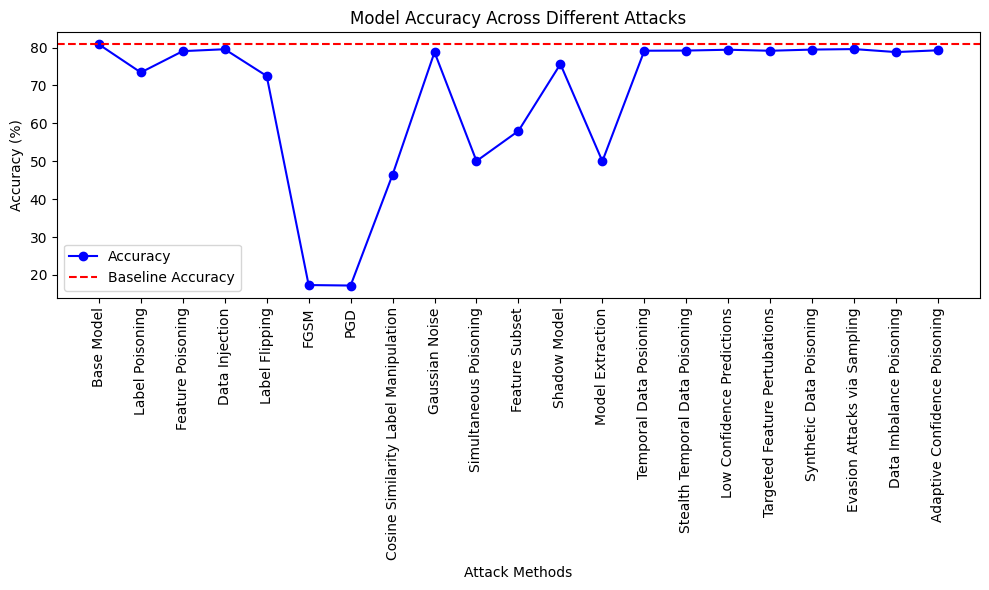

In [ ]:
plt.figure(figsize=(10, 6))
plt.plot(attack_methods, accuracies, marker='o', color='b', label='Accuracy')
plt.axhline(y=80.84, color='r', linestyle='--', label='Baseline Accuracy')  # Baseline line
plt.xticks(rotation=90)
plt.xlabel('Attack Methods')
plt.ylabel('Accuracy (%)')
plt.title('Model Accuracy Across Different Attacks')
plt.legend()
plt.tight_layout()
plt.show()

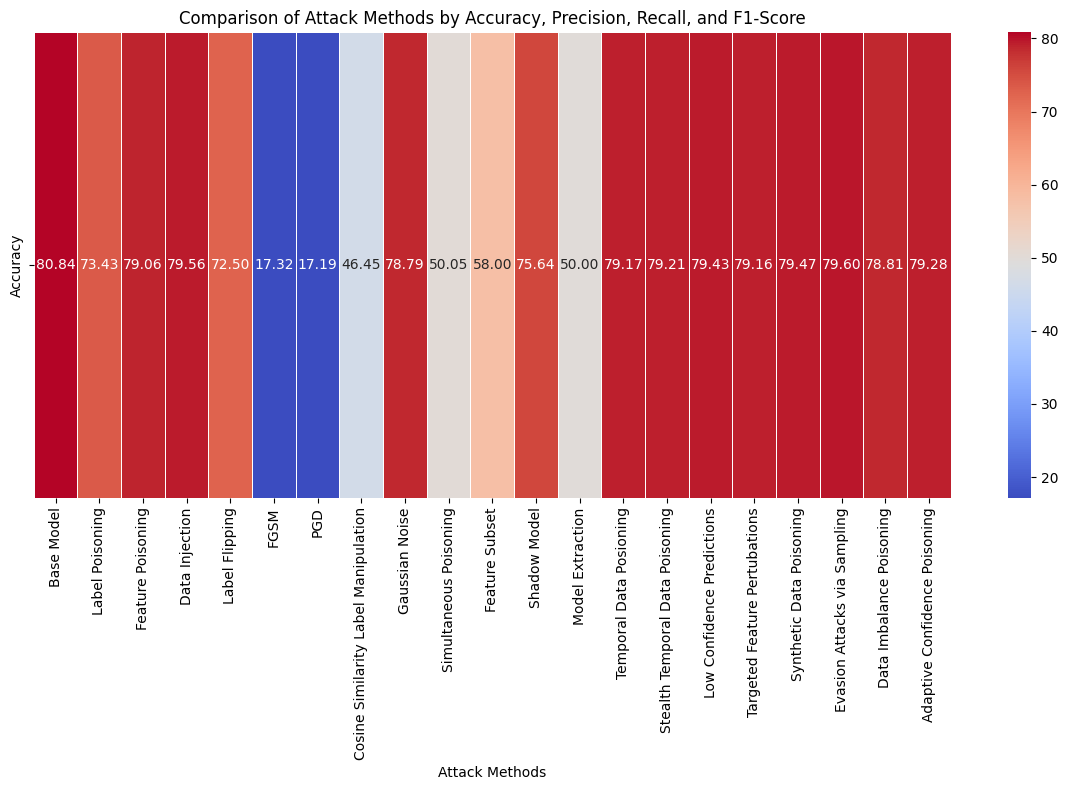

In [ ]:
attack_metrics = {
    'Attack Methods': attack_methods,
    'Accuracy': accuracies}

# Creating DataFrame
df_metrics = pd.DataFrame(attack_metrics)
df_metrics.set_index('Attack Methods', inplace=True)

# Creating heatmap
plt.figure(figsize=(12, 8))
sns.heatmap(df_metrics.T, annot=True, cmap='coolwarm', fmt='.2f', linewidths=0.5)
plt.title('Comparison of Attack Methods by Accuracy, Precision, Recall, and F1-Score')
plt.tight_layout()
plt.show()